In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cleaning_functions import *

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

from skopt import BayesSearchCV

OLD MODELS

In [56]:
#Day 2 Model 1
new_model1 = xgb.XGBClassifier(scale_pos_weight=60, max_depth=11,learning_rate=0.075, n_estimators=110, objective='binary:logistic',
                         booster='gbtree', subsample=0.2, eval_metric='auc',colsample_bytree=0.9,
                         colsample_bynode=0.65, max_delta_step=10, gamma=0.025, reg_alpha=0.1, reg_lambda=0)
new_model1.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.65, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.025, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.075, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=10,
              max_depth=11, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=110, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [100]:
#Day 2 Model 2
new_model2 = xgb.XGBClassifier(scale_pos_weight=60, max_depth=11,learning_rate=0.1, n_estimators=120, objective='binary:logistic',
                         booster='gbtree', subsample=0.18, eval_metric='auc',colsample_bytree=0.9,
                         colsample_bynode=1.0, max_delta_step=3, gamma=0.5, reg_alpha=3.2, reg_lambda=0.4)

new_model2.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1.0, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=3,
              max_depth=11, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [105]:
#Day 2 Model 3
new_model3 = xgb.XGBClassifier(scale_pos_weight=60, max_depth=12,learning_rate=0.1, n_estimators=180, objective='binary:logistic',
                         booster='gbtree', subsample=0.185, eval_metric='auc',colsample_bytree=0.6,
                         colsample_bynode=0.9, max_delta_step=5, gamma=0.35, reg_alpha=0.8, reg_lambda=0.3)

new_model3.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.9, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.35, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=5,
              max_depth=12, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

PREDICTION AND SUBMISSION OF REAL TEST DATA

In [2]:
#Import files
test = pd.read_csv('../cleaned_data/test_cleaned.csv')
X_TEST = test.drop(['individualnumber', 'gender', 'city_code', 'is_large_city'], axis=1).copy()
X_TEST = pd.get_dummies(X_TEST, ['category_number'])

In [108]:
#Use model to make predictions
model = new_model3
y_predict = model.predict(X_TEST)
submission = pd.DataFrame()
submission['individualnumber'] = test['individualnumber']
submission['response'] = y_predict
submission.to_csv('./submissions/submission_day2_2.csv', index=False)

PARAMETER TUNING

In [18]:
train = pd.read_csv('../organized_data/train_organized.csv')
train = pd.get_dummies(train, columns=['category_number'])
X = train.drop(['response', 'city_code', 'is_large_city'], axis=1).copy()
y = train['response'].copy()

In [50]:
def cv_creator(num):
    train_val_test_sets = []
    for i in range(num):
        #Split data for train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=i)

        #validation: Drop Useless Cols | Fill NaN
        X_val.drop(['individualnumber', 'gender'], axis=1, inplace=True)
        X_val.drop(columns=["level1_relevant_category_volume_per_day", "level2_relevant_category_volume_per_day", "level3_relevant_category_volume_per_day", "level4_relevant_category_volume_per_day", "level1_relevant_category_quantity_per_day", "level2_relevant_category_quantity_per_day", "level3_relevant_category_quantity_per_day", "level4_relevant_category_quantity_per_day", "discount_per_day", "total_money_spent_per_day"], inplace=True)
        X_val["months_since_last_shopping"].fillna(12, inplace=True)
        X_val["age"].fillna(0, inplace=True)
        X_val.age.iloc[X_val.query("age<=0").index] = X_val.age.median()

        #test: Drop Useless Cols | Fill Nan
        X_test.drop(['individualnumber', 'gender'], axis=1, inplace=True)
        X_test.drop(columns=["level1_relevant_category_volume_per_day", "level2_relevant_category_volume_per_day", "level3_relevant_category_volume_per_day", "level4_relevant_category_volume_per_day", "level1_relevant_category_quantity_per_day", "level2_relevant_category_quantity_per_day", "level3_relevant_category_quantity_per_day", "level4_relevant_category_quantity_per_day", "discount_per_day", "total_money_spent_per_day"], inplace=True)
        X_test["months_since_last_shopping"].fillna(12, inplace=True)
        X_test["age"].fillna(0, inplace=True)
        X_test.age.iloc[X_test.query("age<=0").index] = X_test.age.median()

        #train: Clean Outliers
        X_train['response'] = y_train
        X_train = clean_isolation_forest(train=X_train, anomalies=0.01)
        X_train = clean_isolation_forest_lower(train=X_train, anomalies=0.008)

        #train: Drop Useless Cols | Fill NaN
        y_train = X_train['response'].copy()
        X_train.drop(['response', 'individualnumber', 'gender'], axis=1, inplace=True)
        X_train.age.iloc[X_train.query("age<=0").index] = X_train.age.median()
        #####
        print('train ratio: {}\nvalid ratio: {}\ntest ratio:{}'.format(sum(y_train)/len(y_train),sum(y_val)/len(y_val),sum(y_test)/len(y_test)))
        print('#0/#1 is {}'.format((len(y)-sum(y))/sum(y)))
        train_val_test_set = [[X_train,y_train],[X_val,y_val],[X_test,y_test]]
        train_val_test_sets.append(train_val_test_set)
    return train_val_test_sets

In [52]:
cv_list = cv_creator(5)

c:\Users\tree\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\tree\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


IndexError: index 3359 is out of bounds for axis 0 with size 2623

In [10]:
#TUNING ROUND 1
param_grid = {'gamma':[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
              'learning_rate':[0.075, 0.1, 0.125],
              'max_delta_step':[0,1,5,10,20],
              'max_depth':[9, 10, 11, 12],
              'n_estimators':[90, 95, 100, 105, 110, 120, 150, 180],
              'subsample':[0.175, 0.2, 0.225],
              'colsample_bynode':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
              'reg_alpha':[0, 0.1, 0.2, 0.4, 0.8],
              'reg_lambda':[0, 0.1, 0.2, 0.4, 0.8]}

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
bcvj = int(gcvj)

xgb0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          scale_pos_weight=60)

model = BayesSearchCV(estimator=xgb0, search_spaces=param_grid, n_iter=100, scoring='f1', cv=5, return_train_score=True, verbose=3)
model.fit(X_train, y_train)

df = pd.DataFrame(model.cv_results_)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Test\n')
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test,test_pred))
print('f05:{}'.format(metrics.fbeta_score(y_test, test_pred, beta=0.5)))
print('Train\n')
print(confusion_matrix(y_train, train_pred))
print(classification_report(y_train,train_pred))
print('f05:{}'.format(metrics.fbeta_score(y_train, train_pred, beta=0.5)))

bp = model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bynode=0.7, colsample_bytree=0.7, gamma=0.3, learning_rate=0.075, max_delta_step=1, max_depth=11, n_estimators=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.2;, score=(train=0.348, test=0.205) total time=   0.4s
[CV 2/5] END colsample_bynode=0.7, colsample_bytree=0.7, gamma=0.3, learning_rate=0.075, max_delta_step=1, max_depth=11, n_estimators=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.2;, score=(train=0.339, test=0.220) total time=   0.4s
[CV 3/5] END colsample_bynode=0.7, colsample_bytree=0.7, gamma=0.3, learning_rate=0.075, max_delta_step=1, max_depth=11, n_estimators=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.2;, score=(train=0.427, test=0.171) total time=   0.4s
[CV 4/5] END colsample_bynode=0.7, colsample_bytree=0.7, gamma=0.3, learning_rate=0.075, max_delta_step=1, max_depth=11, n_estimators=150, reg_alpha=0.0, reg_lambda=0.1, subsample=0.2;, score=(train=0.389, test=0.254) total time= 

In [11]:
sorted_df = df.sort_values(by='rank_test_score')
sorted_df.to_csv('./parameter_search/stats_round1.csv',index=False)
bp

OrderedDict([('colsample_bynode', 0.3),
             ('colsample_bytree', 0.9),
             ('gamma', 0.35),
             ('learning_rate', 0.1),
             ('max_delta_step', 5),
             ('max_depth', 10),
             ('n_estimators', 150),
             ('reg_alpha', 0.4),
             ('reg_lambda', 0.1),
             ('subsample', 0.175)])

In [15]:
#TUNING ROUND 2
param_grid = {'gamma':[0.35, 0.4, 0.45],
              'learning_rate':[0.075, 0.1, 0.125],
              'max_delta_step':[0, 5, 10],
              'max_depth':[9, 10, 11, 12],
              'n_estimators':[90, 100, 110, 120, 150, 180, 200],
              'subsample':[0.175, 0.2],
              'colsample_bynode':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
              'reg_alpha':[0, 0.1, 0.2, 0.4, 0.8],
              'reg_lambda':[0, 0.1, 0.2, 0.3, 0.4]}

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
bcvj = int(gcvj)

xgb0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          scale_pos_weight=60)

model = BayesSearchCV(estimator=xgb0, search_spaces=param_grid, n_iter=100, scoring='f1', cv=5, return_train_score=True, verbose=3)
model.fit(X_train, y_train)

df2 = pd.DataFrame(model.cv_results_)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Test\n')
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test,test_pred))
print('f05:{}'.format(metrics.fbeta_score(y_test, test_pred, beta=0.5)))
print('Train\n')
print(confusion_matrix(y_train, train_pred))
print(classification_report(y_train,train_pred))
print('f05:{}'.format(metrics.fbeta_score(y_train, train_pred, beta=0.5)))

bp2 = model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bynode=0.8, colsample_bytree=0.8, gamma=0.45, learning_rate=0.1, max_delta_step=0, max_depth=11, n_estimators=200, reg_alpha=0.0, reg_lambda=0.2, subsample=0.18519648270709133;, score=(train=0.938, test=0.311) total time=   0.7s
[CV 2/5] END colsample_bynode=0.8, colsample_bytree=0.8, gamma=0.45, learning_rate=0.1, max_delta_step=0, max_depth=11, n_estimators=200, reg_alpha=0.0, reg_lambda=0.2, subsample=0.18519648270709133;, score=(train=0.950, test=0.462) total time=   0.7s
[CV 3/5] END colsample_bynode=0.8, colsample_bytree=0.8, gamma=0.45, learning_rate=0.1, max_delta_step=0, max_depth=11, n_estimators=200, reg_alpha=0.0, reg_lambda=0.2, subsample=0.18519648270709133;, score=(train=0.958, test=0.327) total time=   0.5s
[CV 4/5] END colsample_bynode=0.8, colsample_bytree=0.8, gamma=0.45, learning_rate=0.1, max_delta_step=0, max_depth=11, n_estimators=200, reg_alpha=0.0, reg_lambda=0.2, subsample=0.1851

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bynode=0.9, colsample_bytree=0.6, gamma=0.35, learning_rate=0.075, max_delta_step=10, max_depth=12, n_estimators=200, reg_alpha=0.8, reg_lambda=0.4, subsample=0.175;, score=(train=0.908, test=0.449) total time=   0.6s
[CV 2/5] END colsample_bynode=0.9, colsample_bytree=0.6, gamma=0.35, learning_rate=0.075, max_delta_step=10, max_depth=12, n_estimators=200, reg_alpha=0.8, reg_lambda=0.4, subsample=0.175;, score=(train=0.910, test=0.531) total time=   0.6s
[CV 3/5] END colsample_bynode=0.9, colsample_bytree=0.6, gamma=0.35, learning_rate=0.075, max_delta_step=10, max_depth=12, n_estimators=200, reg_alpha=0.8, reg_lambda=0.4, subsample=0.175;, score=(train=0.926, test=0.245) total time=   0.6s
[CV 4/5] END colsample_bynode=0.9, colsample_bytree=0.6, gamma=0.35, learning_rate=0.075, max_delta_step=10, max_depth=12, n_estimators=200, reg_alpha=0.8, reg_lambda=0.4, subsample=0.175;, score=(train=0.908, test=0.4

In [16]:
sorted_df2 = df2.sort_values(by='rank_test_score')
sorted_df2.to_csv('./parameter_search/stats_round2.csv',index=False)
bp2

OrderedDict([('colsample_bynode', 0.9),
             ('colsample_bytree', 0.6),
             ('gamma', 0.35),
             ('learning_rate', 0.1),
             ('max_delta_step', 5),
             ('max_depth', 12),
             ('n_estimators', 180),
             ('reg_alpha', 0.8),
             ('reg_lambda', 0.3),
             ('subsample', 0.18503578676524662)])

In [33]:
#TUNING ROUND 3
param_grid = {'gamma':[0.3, 0.35, 0.4, 0.45, 0.5],
              'learning_rate':[0.075, 0.08, 0.09, 0.1, 0.125],
              'max_delta_step':[0,1,2,3,5,10],
              'max_depth':[11, 12, 13, 14, 15],
              'n_estimators':[100, 120, 150, 180, 200, 220, 250],
              'subsample':[0.17, 0.175, 0.18, 0.185, 0.19, 0.195, 0.2],
              'colsample_bynode':[ 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
              'reg_alpha':[0, 0.8, 1.6, 3.2, 6.4],
              'reg_lambda':[0.4, 0.8, 1.6, 3.2]}

gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
bcvj = int(gcvj)

xgb0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          scale_pos_weight=60)

model = BayesSearchCV(estimator=xgb0, search_spaces=param_grid, n_iter=100, scoring='f1', cv=5, return_train_score=True, verbose=3)
model.fit(X_train, y_train)

df3 = pd.DataFrame(model.cv_results_)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Test\n')
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test,test_pred))
print('f05:{}'.format(metrics.fbeta_score(y_test, test_pred, beta=0.5)))
print('Train\n')
print(confusion_matrix(y_train, train_pred))
print(classification_report(y_train,train_pred))
print('f05:{}'.format(metrics.fbeta_score(y_train, train_pred, beta=0.5)))

bp3 = model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bynode=1.0, colsample_bytree=0.6, gamma=0.4, learning_rate=0.09, max_delta_step=2, max_depth=13, n_estimators=200, reg_alpha=0.0, reg_lambda=1.6, subsample=0.17;, score=(train=0.790, test=0.250) total time=   0.4s
[CV 2/5] END colsample_bynode=1.0, colsample_bytree=0.6, gamma=0.4, learning_rate=0.09, max_delta_step=2, max_depth=13, n_estimators=200, reg_alpha=0.0, reg_lambda=1.6, subsample=0.17;, score=(train=0.763, test=0.226) total time=   0.5s
[CV 3/5] END colsample_bynode=1.0, colsample_bytree=0.6, gamma=0.4, learning_rate=0.09, max_delta_step=2, max_depth=13, n_estimators=200, reg_alpha=0.0, reg_lambda=1.6, subsample=0.17;, score=(train=0.743, test=0.237) total time=   0.4s
[CV 4/5] END colsample_bynode=1.0, colsample_bytree=0.6, gamma=0.4, learning_rate=0.09, max_delta_step=2, max_depth=13, n_estimators=200, reg_alpha=0.0, reg_lambda=1.6, subsample=0.17;, score=(train=0.772, test=0.350) total time= 

In [35]:
sorted_df3 = df3.sort_values(by='rank_test_score')
sorted_df3.to_csv('./parameter_search/stats_round3.csv',index=False)
bp3

OrderedDict([('colsample_bynode', 1.0),
             ('colsample_bytree', 0.9),
             ('gamma', 0.5),
             ('learning_rate', 0.1),
             ('max_delta_step', 3),
             ('max_depth', 11),
             ('n_estimators', 120),
             ('reg_alpha', 3.2),
             ('reg_lambda', 0.4),
             ('subsample', 0.18)])

RAPID TESTING

In [38]:
train = pd.read_csv('../organized_data/train_organized.csv')
train = pd.get_dummies(train, columns=['category_number'])
X = train.drop(['response', 'city_code', 'is_large_city'], axis=1).copy()
y = train['response'].copy()

In [54]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

#Drop useless cols of test
X_test.drop(['individualnumber', 'gender'], axis=1, inplace=True)
X_test.drop(columns=["level1_relevant_category_volume_per_day", "level2_relevant_category_volume_per_day", "level3_relevant_category_volume_per_day", "level4_relevant_category_volume_per_day", "level1_relevant_category_quantity_per_day", "level2_relevant_category_quantity_per_day", "level3_relevant_category_quantity_per_day", "level4_relevant_category_quantity_per_day", "discount_per_day", "total_money_spent_per_day"], inplace=True)
X_test["months_since_last_shopping"].fillna(12, inplace=True)
X_test["age"].fillna(X_test.age.median(), inplace=True)
X_test.age.iloc[X_test.query("age<=0").index] = X_test.age.median()

#Clean outliers from train
X_train['response'] = y_train
X_train = clean_isolation_forest(train=X_train, anomalies=0.01)
X_train = clean_isolation_forest_lower(train=X_train, anomalies=0.008)

#Drop useless from train and clean data
y_train = X_train['response'].copy()
X_train.drop(['response', 'individualnumber', 'gender'], axis=1, inplace=True)
X_train.age.iloc[X_train.query("age<=0").index] = X_train.age.median()
##
print('train ratio: {}\ntest ratio:{}'.format(sum(y_train)/len(y_train),sum(y_test)/len(y_test)))
print('#0/#1 is {}'.format((len(y)-sum(y))/sum(y)))

c:\Users\tree\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\tree\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\tree\MigrosDatathon\scripts\cleaning_functions.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["anomaly"] = pred


 1    9582
-1      97
Name: anomaly, dtype: int64


c:\Users\tree\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    8643
-1      70
Name: anomaly, dtype: int64
train ratio: 0.01623745992346675
test ratio:0.015858493443122904
#0/#1 is 61.751196172248804


c:\Users\tree\MigrosDatathon\scripts\cleaning_functions.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["anomaly"] = pred
c:\Users\tree\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [37]:
print(X_test.info())
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3279 entries, 7263 to 110
Data columns (total 66 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   hakkedis_amt                       3279 non-null   float64
 1   odul_amt                           3279 non-null   float64
 2   total_money_spent                  3279 non-null   float64
 3   total_discount                     3277 non-null   float64
 4   sanal_percent                      3279 non-null   float64
 5   shop_count                         3279 non-null   float64
 6   months_since_last_shopping         3279 non-null   float64
 7   days_shopped                       3279 non-null   float64
 8   age                                3279 non-null   float64
 9   level1_relevant_category_volume    3279 non-null   float64
 10  level2_relevant_category_volume    3279 non-null   float64
 11  level3_relevant_category_volume    3279 non-null   flo

In [43]:
clf_xgb = xgb.XGBClassifier(scale_pos_weight=62, max_depth=12,learning_rate=0.1, n_estimators=150, objective='binary:logistic',
                         booster='gbtree', subsample=0.2, eval_metric='auc',colsample_bytree=0.2,
                         colsample_bynode=.5, max_delta_step=5, gamma=0.5, reg_alpha=3.2, reg_lambda=0.4)

eval_set = [(X_test,y_test)]
clf_xgb.fit(X_train, y_train, verbose=2, eval_set=eval_set)

[0]	validation_0-auc:0.83828
[2]	validation_0-auc:0.84882
[4]	validation_0-auc:0.85557
[6]	validation_0-auc:0.86826
[8]	validation_0-auc:0.87890
[10]	validation_0-auc:0.89029
[12]	validation_0-auc:0.89050
[14]	validation_0-auc:0.89365
[16]	validation_0-auc:0.89707
[18]	validation_0-auc:0.89501
[20]	validation_0-auc:0.88655
[22]	validation_0-auc:0.89413
[24]	validation_0-auc:0.89179
[26]	validation_0-auc:0.88947
[28]	validation_0-auc:0.89869
[30]	validation_0-auc:0.90034
[32]	validation_0-auc:0.89988
[34]	validation_0-auc:0.90226
[36]	validation_0-auc:0.90019
[38]	validation_0-auc:0.90246
[40]	validation_0-auc:0.90566
[42]	validation_0-auc:0.90410
[44]	validation_0-auc:0.90267
[46]	validation_0-auc:0.90216
[48]	validation_0-auc:0.90777
[50]	validation_0-auc:0.90887
[52]	validation_0-auc:0.90920
[54]	validation_0-auc:0.90613
[56]	validation_0-auc:0.90333
[58]	validation_0-auc:0.90538
[60]	validation_0-auc:0.90117
[62]	validation_0-auc:0.90153
[64]	validation_0-auc:0.90503
[66]	validation

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=0.5, colsample_bytree=0.2,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=5,
              max_depth=12, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [44]:
train_pred = clf_xgb.predict(X_train)
test_pred = clf_xgb.predict(X_test)

print('Test\n')
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test,test_pred))
print(metrics.fbeta_score(y_test, test_pred, beta=0.5))
print('Train\n')
print(confusion_matrix(y_train, train_pred))
print(classification_report(y_train,train_pred))
print(metrics.fbeta_score(y_train, train_pred, beta=0.5))

Test

[[3142   85]
 [  29   23]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3227
           1       0.21      0.44      0.29        52

    accuracy                           0.97      3279
   macro avg       0.60      0.71      0.63      3279
weighted avg       0.98      0.97      0.97      3279

0.23760330578512398
Train

[[9341  171]
 [   2  155]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9512
           1       0.48      0.99      0.64       157

    accuracy                           0.98      9669
   macro avg       0.74      0.98      0.82      9669
weighted avg       0.99      0.98      0.99      9669

0.5304585900068446


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

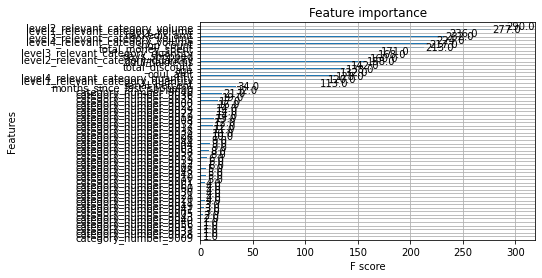

In [46]:
xgb.plot_importance(clf_xgb)

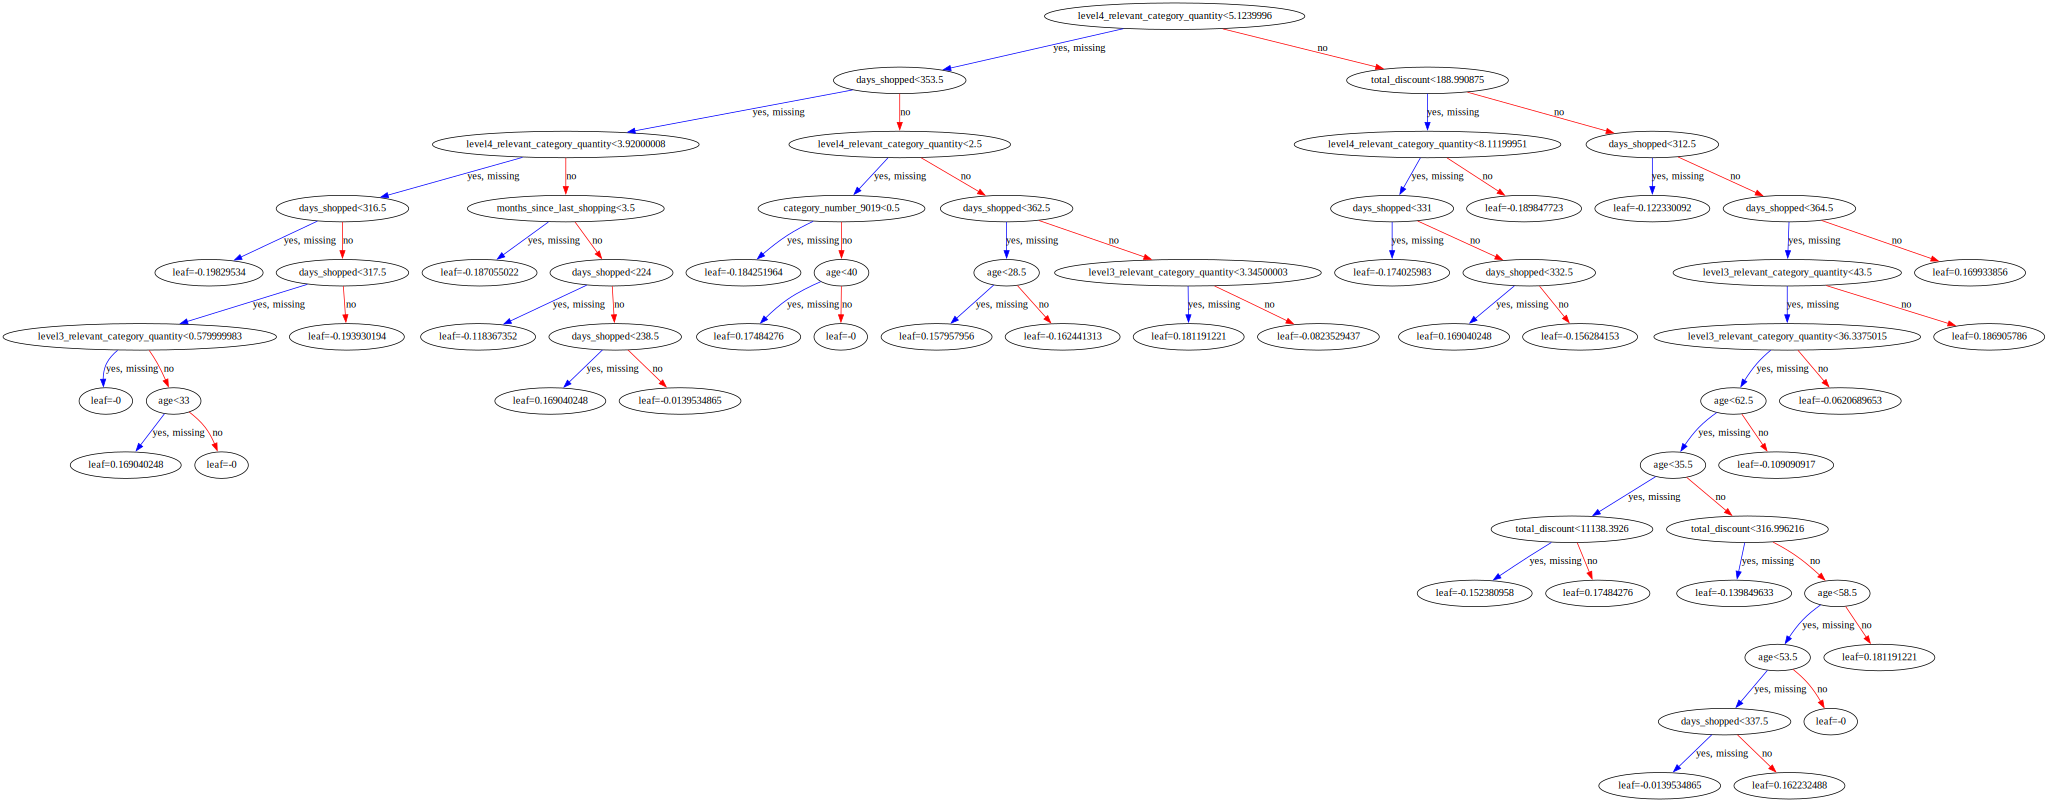

In [45]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
xgb.to_graphviz(clf_xgb)